<a href="https://colab.research.google.com/github/purnimapatel/Human-Activity-recognition/blob/master/Human_Activity_Recognition_using_LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==1.0.0

     |████████████████████████████████| 44.5MB 84kB/s 
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [2]:
from zipfile import ZipFile
file_name="UCI HAR Dataset (1).zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("DONE")

DONE


In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics

In [5]:
#those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [6]:
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

x_train_signals_paths = [
    "/content/UCI HAR Dataset/train/X_train.txt" for signal in INPUT_SIGNAL_TYPES
]
x_test_signals_paths = [
    "/content/UCI HAR Dataset/test/X_test.txt" for signal in INPUT_SIGNAL_TYPES
]

x_train = load_X(x_train_signals_paths)
x_test = load_X(x_test_signals_paths)

In [7]:
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

y_train_path = "/content/UCI HAR Dataset/train/y_train.txt"
y_test_path = "/content/UCI HAR Dataset/test/y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [8]:
print(x_test)
print(x_train)
print(y_test)
print(y_train)

[[[ 0.25717777  0.25717777  0.25717777 ...  0.25717777  0.25717777
    0.25717777]
  [-0.02328523 -0.02328523 -0.02328523 ... -0.02328523 -0.02328523
   -0.02328523]
  [-0.01465376 -0.01465376 -0.01465376 ... -0.01465376 -0.01465376
   -0.01465376]
  ...
  [-0.72000927 -0.72000927 -0.72000927 ... -0.72000927 -0.72000927
   -0.72000927]
  [ 0.27680105  0.27680105  0.27680105 ...  0.27680105  0.27680105
    0.27680105]
  [-0.0579783  -0.0579783  -0.0579783  ... -0.0579783  -0.0579783
   -0.0579783 ]]

 [[ 0.28602672  0.28602672  0.28602672 ...  0.28602672  0.28602672
    0.28602672]
  [-0.01316336 -0.01316336 -0.01316336 ... -0.01316336 -0.01316336
   -0.01316336]
  [-0.11908252 -0.11908252 -0.11908252 ... -0.11908252 -0.11908252
   -0.11908252]
  ...
  [-0.6980908  -0.6980908  -0.6980908  ... -0.6980908  -0.6980908
   -0.6980908 ]
  [ 0.28134292  0.28134292  0.28134292 ...  0.28134292  0.28134292
    0.28134292]
  [-0.08389802 -0.08389802 -0.08389802 ... -0.08389802 -0.08389802
   -0.08

In [9]:
training_data_count = len(x_train)
test_data_count = len(x_test) 
print(training_data_count)
print(test_data_count)

7352
2947


In [10]:
n_steps=len(x_train[0])
n_input=len(x_train[0][0])
print(n_steps)
print(n_input)

561
9


In [11]:
#internal structure of the neural network 
n_hidden = 32 # Hidden layer num of features
n_classes = 6

In [12]:
 #Training

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training
# Some debugging info
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(x_test.shape, y_test.shape, np.mean(x_test), np.std(x_test))


(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 561, 9) (2947, 1) -0.50925714 0.525582


In [13]:
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters.
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network.
    # Note, some code of this notebook is inspired from an slightly different
    # RNN architecture used on another dataset, some of the credits goes to
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input])
    # new shape: (n_steps*batch_size, n_input)

    # ReLU activation, thanks to Yu Zhao for adding this improvement here:
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0)
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many-to-one" style classifier,
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]

    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.

    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index]

    return batch_s


def one_hot(y_, n_classes=n_classes):
    # Function to encode neural one-hot output labels from number indexes
    # e.g.:
    # one_hot(y_=[[5], [0], [3]], n_classes=6):
    #     return [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]

    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


In [14]:
#Let's build the neural network:
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [16]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(x_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs,
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)

    # Evaluate network only at some steps for faster training:
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + ":   Batch Loss = " + "{:.6f}".format(loss) + ", Accuracy = {}".format(acc))

        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy],
            feed_dict={
                x: x_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + "Batch Loss = {}".format(loss) + ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: x_test,
        y: one_hot(y_test)
    }
)
test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + "Batch Loss = {}".format(final_loss) + ", Accuracy = {}".format(accuracy))


Training iter #1500:   Batch Loss = 3.127519, Accuracy = 0.20666666328907013
PERFORMANCE ON TEST SET: Batch Loss = 2.723475694656372, Accuracy = 0.27010518312454224
Training iter #30000:   Batch Loss = 1.787492, Accuracy = 0.5460000038146973
PERFORMANCE ON TEST SET: Batch Loss = 1.776181936264038, Accuracy = 0.5188326835632324
Training iter #60000:   Batch Loss = 1.548670, Accuracy = 0.6639999747276306
PERFORMANCE ON TEST SET: Batch Loss = 1.5227867364883423, Accuracy = 0.6392942070960999
Training iter #90000:   Batch Loss = 1.350784, Accuracy = 0.718666672706604
PERFORMANCE ON TEST SET: Batch Loss = 1.335038423538208, Accuracy = 0.7139464020729065
Training iter #120000:   Batch Loss = 1.180631, Accuracy = 0.7699999809265137
PERFORMANCE ON TEST SET: Batch Loss = 1.221150279045105, Accuracy = 0.7543264627456665
Training iter #150000:   Batch Loss = 1.122570, Accuracy = 0.7820000052452087
PERFORMANCE ON TEST SET: Batch Loss = 1.1719768047332764, Accuracy = 0.7831693291664124
Training ite

Testing Accuracy: 86.63046956062317%

Precision: 86.98466418351313%
Recall: 86.63047166610112%
f1_score: 86.50732876802357%

Confusion Matrix:
[[489   3   4   0   0   0]
 [ 87 358  26   0   0   0]
 [ 34  60 326   0   0   0]
 [  0   3   0 389  94   5]
 [  0   2   0  68 462   0]
 [  0   2   0   0   6 529]]

Confusion matrix (normalised to % of total test data):
[[16.593145    0.10179844  0.13573125  0.          0.          0.        ]
 [ 2.9521546  12.147947    0.88225317  0.          0.          0.        ]
 [ 1.1537156   2.0359688  11.062097    0.          0.          0.        ]
 [ 0.          0.10179844  0.         13.199864    3.1896844   0.16966406]
 [ 0.          0.06786563  0.          2.3074312  15.67696     0.        ]
 [ 0.          0.06786563  0.          0.          0.20359688 17.950459  ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


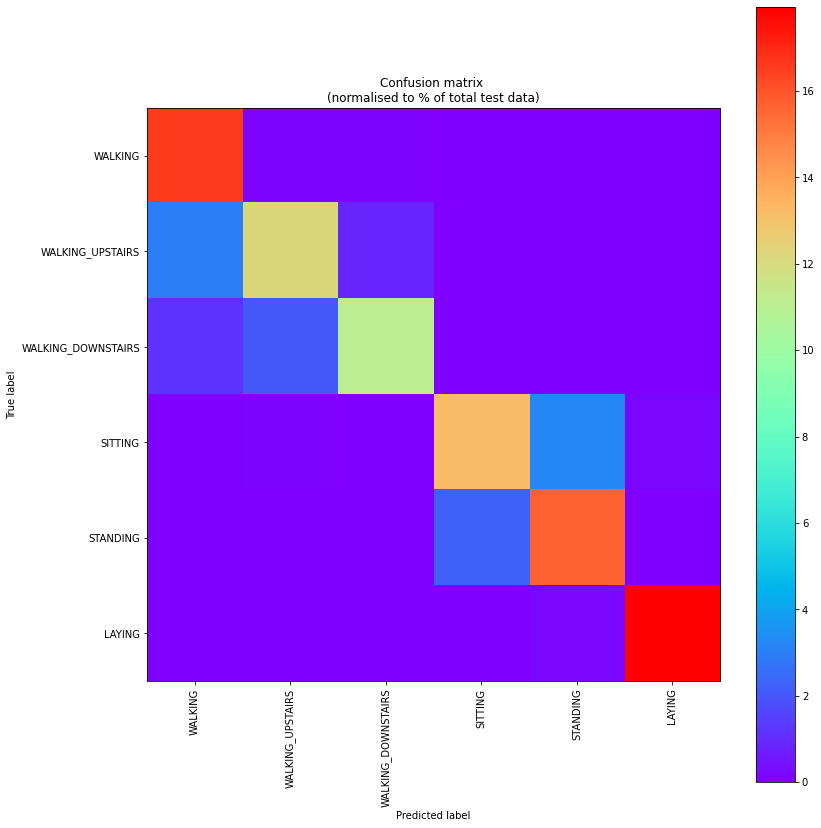

In [17]:
#visualiZation of the result
predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
